In [24]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import pandas as pd
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv, global_mean_pool
from utils import get_feature_propagation
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from Models.GAT import GATClassification
from Models.GraphSage import GraphSAGEClassfication
from Models.Transformer import TransformerClassification
import matplotlib.pyplot as plt

In [25]:
data = torch.load('Data/santiago_zero_ismt.pt')
data.y = data.x[:,-1] # Select GSE
data.x = data.x[:, 2:8]
print(data)
print(data.x)
print(data.y)
print(data.edge_index)
print(data.edge_attributes)

Data(x=[337374, 6], edge_index=[2, 641693], edge_attributes=[641693, 2], y=[337374])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([[     0,      1,      2,  ..., 337372, 337373, 337373],
        [  4237,   4241,    480,  ..., 184408, 239479,   7705]])
tensor([[80.8500,  5.8000],
        [18.8300,  1.3000],
        [16.0600,  1.1000],
        ...,
        [33.0400,  4.1000],
        [ 2.5300,  0.2000],
        [ 6.4800,  0.6000]])


In [26]:
data.x = get_feature_propagation(data)

Starting feature filling
tensor([[-1.8762,  0.0880,  1.8812, -0.7552, -2.0797, -1.2788],
        [ 0.2155, -0.1407, -0.2000,  0.7840,  0.9977,  0.7484],
        [ 0.0507, -1.1760, -0.3934,  1.3322,  0.4679,  0.7087],
        ...,
        [ 1.0445, -1.0450, -1.3092,  1.1516,  1.1633,  1.0873],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 1.2992, -0.1245, -1.1497,  0.2336,  1.0391,  0.9675]])
Feature filling completed. It took: 2.31s


In [27]:
count_gse = {}
for i in data.y.tolist():
    if i not in count_gse:
        count_gse[i] = 0
    count_gse[i] += 1
count_gse

{1.0: 81492, 2.0: 75116, 3.0: 130226, 0.0: 49543, 4.0: 997}

In [28]:
index_list = data.edge_index.flatten().unique().tolist()

# Porcentaje de índices para cada conjunto
train_percentage = 0.8
val_percentage = 0.1

# Dividir en conjuntos de entrenamiento y prueba
train_index, remaining_index = train_test_split(index_list, train_size=train_percentage, random_state=42)

# Dividir el resto en conjuntos de validación y prueba
val_index, test_index = train_test_split(remaining_index, train_size=val_percentage / (1 - train_percentage), random_state=42)

print("Training set length:", len(train_index))
print("Validation set length:", len(val_index))
print("Test set length:", len(test_index))

n_nodes, n_features = data.x.shape

train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)

train_mask[train_index] = True
val_mask[val_index] = True
test_mask[test_index] = True
data['train_mask'] = train_mask
data['val_mask'] = val_mask
data['test_mask'] = test_mask

Training set length: 269835
Validation set length: 33729
Test set length: 33730


## GraphSage Classification

In [32]:
in_features = data.x.shape[1]
hidden_features = 64
out_features = 6
num_layers = 1
epochs = 150
lr = 0.01

model = GraphSAGEClassfication(in_features, hidden_features, out_features, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)[mask]
    loss = F.cross_entropy(out, data.y[mask].long())
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)[mask]
        pred = torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, data.y[mask].long())
        acc = accuracy_score(data.y[mask].long(), pred)
        recall = recall_score(data.y[mask].long(), pred, average='weighted')
        f1 = f1_score(data.y[mask].long(), pred, average='weighted')
    return loss.item(), acc, recall, f1

train_losses = []
val_losses = []
acc_scores = []
recall_scores = []
f1_scores = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_loss, val_acc, val_recall, val_f1 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    acc_scores.append(val_acc)
    recall_scores.append(val_recall)
    f1_scores.append(val_f1)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

_, test_acc, test_recall, test_f1 = evaluate_model(model, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Epoch: 001, Train Loss: 1.8240, Val Loss: 1.6723, Val Acc: 0.3108, Val Recall: 0.3108, Val F1: 0.2670
Epoch: 002, Train Loss: 1.6805, Val Loss: 1.5513, Val Acc: 0.3750, Val Recall: 0.3750, Val F1: 0.2206
Epoch: 003, Train Loss: 1.5652, Val Loss: 1.4754, Val Acc: 0.3826, Val Recall: 0.3826, Val F1: 0.2528
Epoch: 004, Train Loss: 1.4979, Val Loss: 1.4509, Val Acc: 0.3844, Val Recall: 0.3844, Val F1: 0.2697
Epoch: 005, Train Loss: 1.4809, Val Loss: 1.4332, Val Acc: 0.3822, Val Recall: 0.3822, Val F1: 0.2733
Epoch: 006, Train Loss: 1.4678, Val Loss: 1.4148, Val Acc: 0.3971, Val Recall: 0.3971, Val F1: 0.3130
Epoch: 007, Train Loss: 1.4534, Val Loss: 1.4088, Val Acc: 0.3985, Val Recall: 0.3985, Val F1: 0.3131
Epoch: 008, Train Loss: 1.4497, Val Loss: 1.4037, Val Acc: 0.3984, Val Recall: 0.3984, Val F1: 0.3186
Epoch: 009, Train Loss: 1.4414, Val Loss: 1.3946, Val Acc: 0.4048, Val Recall: 0.4048, Val F1: 0.3045
Epoch: 010, Train Loss: 1.4259, Val Loss: 1.3874, Val Acc: 0.4063, Val Recall: 0.4

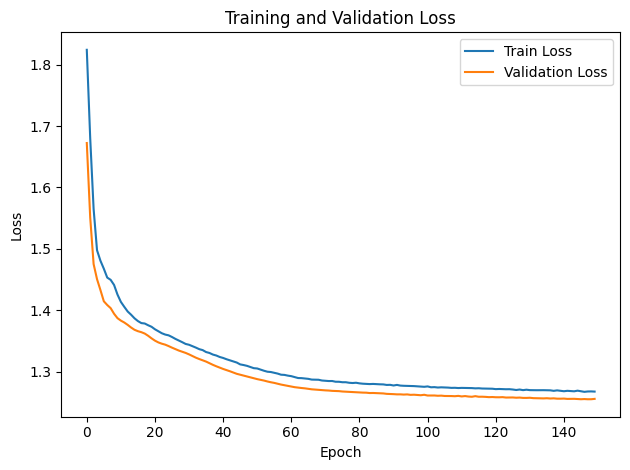

In [33]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## GAT Classification

In [13]:
in_features = data.x.shape[1]
hidden_features = 64
out_features = 6
num_layers = 1
epochs = 150
lr = 0.005
num_heads = 2

model = GATClassification(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads, num_layers=2, dropout=0.6)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    loss = F.cross_entropy(out, data.y[mask].long())
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        pred = torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, data.y[mask].long())
        acc = accuracy_score(data.y[mask].long(), pred)
        recall = recall_score(data.y[mask].long(), pred, average='weighted')
        f1 = f1_score(data.y[mask].long(), pred, average='weighted')
    return loss.item(), acc, recall, f1

train_losses = []
val_losses = []
acc_scores = []
recall_scores = []
f1_scores = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_loss, val_acc, val_recall, val_f1 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    acc_scores.append(val_acc)
    recall_scores.append(val_recall)
    f1_scores.append(val_f1)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

_, test_acc, test_recall, test_f1 = evaluate_model(model, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Epoch: 001, Train Loss: 1.9151, Val Loss: 1.6502, Val Acc: 0.3793, Val Recall: 0.3793, Val F1: 0.3127
Epoch: 002, Train Loss: 1.7630, Val Loss: 1.5972, Val Acc: 0.3753, Val Recall: 0.3753, Val F1: 0.2838
Epoch: 003, Train Loss: 1.7029, Val Loss: 1.5678, Val Acc: 0.3805, Val Recall: 0.3805, Val F1: 0.2900
Epoch: 004, Train Loss: 1.6620, Val Loss: 1.5348, Val Acc: 0.3895, Val Recall: 0.3895, Val F1: 0.3189
Epoch: 005, Train Loss: 1.6318, Val Loss: 1.5022, Val Acc: 0.4172, Val Recall: 0.4172, Val F1: 0.3293
Epoch: 006, Train Loss: 1.6107, Val Loss: 1.4758, Val Acc: 0.4190, Val Recall: 0.4190, Val F1: 0.3315
Epoch: 007, Train Loss: 1.5953, Val Loss: 1.4557, Val Acc: 0.4194, Val Recall: 0.4194, Val F1: 0.3309
Epoch: 008, Train Loss: 1.5849, Val Loss: 1.4407, Val Acc: 0.4175, Val Recall: 0.4175, Val F1: 0.3268
Epoch: 009, Train Loss: 1.5721, Val Loss: 1.4309, Val Acc: 0.4142, Val Recall: 0.4142, Val F1: 0.3190
Epoch: 010, Train Loss: 1.5612, Val Loss: 1.4260, Val Acc: 0.4078, Val Recall: 0.4

KeyboardInterrupt: 

## TransfomerConv

In [16]:
in_features = data.x.shape[1]
hidden_features = 64
out_features = 6
num_layers = 2
epochs = 150
lr = 0.1
num_heads = 2

model = TransformerRegression(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    loss = criterion(out, data.y[mask].view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        mse = criterion(out, data.y[mask].view(-1, 1))
        r2 = r2_score(data.y[mask].view(-1, 1), out)
        mae = mean_absolute_error(out, data.y[mask].view(-1, 1))
        rmse = torch.sqrt(mse)
    return mse.item(), rmse, mae, r2

train_losses = []
val_losses = []
train_maes = []
val_maes = []
val_rmses = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_mse, val_rmse, val_mae, r2 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_mse:.4f}, Val RMSE: {val_rmse:.4f} Val R2: {r2:.4f}')

test_mse, test_rmse, test_mae, test_r2 = evaluate_model(model, data, data.test_mask)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Epoch: 001, Train Loss: 1710.4404, Val Loss: 32883.6133, Val RMSE: 181.3384 Val R2: -521872.3368
Epoch: 002, Train Loss: 62878.1914, Val Loss: 694.4125, Val RMSE: 26.3517 Val R2: -11019.5474
Epoch: 003, Train Loss: 1392.1504, Val Loss: 1406.0488, Val RMSE: 37.4973 Val R2: -22313.4406
Epoch: 004, Train Loss: 2522.0806, Val Loss: 3608.8936, Val RMSE: 60.0741 Val R2: -57273.2940
Epoch: 005, Train Loss: 6727.0889, Val Loss: 2542.9031, Val RMSE: 50.4272 Val R2: -40355.6841
Epoch: 006, Train Loss: 4895.0356, Val Loss: 543.6850, Val RMSE: 23.3171 Val R2: -8627.4532
Epoch: 007, Train Loss: 1476.9976, Val Loss: 398.5207, Val RMSE: 19.9630 Val R2: -6323.6500
Epoch: 008, Train Loss: 1805.5237, Val Loss: 1256.2605, Val RMSE: 35.4438 Val R2: -19936.2533
Epoch: 009, Train Loss: 3804.2686, Val Loss: 729.2445, Val RMSE: 27.0045 Val R2: -11572.3410
Epoch: 010, Train Loss: 2577.4172, Val Loss: 95.8467, Val RMSE: 9.7901 Val R2: -1520.1174
Epoch: 011, Train Loss: 1085.4829, Val Loss: 86.2536, Val RMSE: 9.

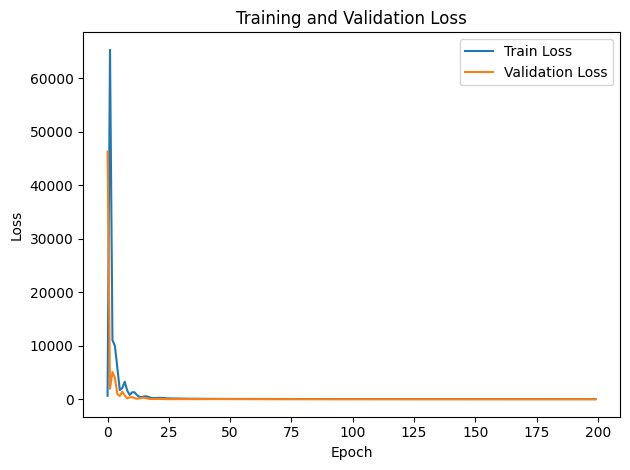

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Classic Regression

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [7]:
data_tensor = torch.cat((data.x, data.y.unsqueeze(1), data.train_mask.unsqueeze(1), data.test_mask.unsqueeze(1)), dim=1)
df_ismt = pd.DataFrame(data_tensor.numpy(), columns=['beautiful','boring','depressing','lively','safe','wealthy',
                                                     'avg_gse', 'train', 'test'])

train_split = df_ismt[df_ismt.train == 1]
test_split = df_ismt[df_ismt.test == 1]

X_train, y_train = train_split[['beautiful','boring','depressing','lively','safe','wealthy']], train_split.avg_gse
X_test, y_test = test_split[['beautiful','boring','depressing','lively','safe','wealthy']], test_split.avg_gse

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [9]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.4058
Recall: 0.4058
F1-Score: 0.3139


c:\Users\Lenovo\OneDrive - Universidad Católica de Chile\Documentos\Tesis_Master\tesisenv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Support Vector Classifier

In [40]:
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## Decision Tree Classifier

In [10]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5273
Recall: 0.5273
F1-Score: 0.5264


## Random Forest Classifier

In [11]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6039
Recall: 0.6039
F1-Score: 0.5905
